In [1]:
## Import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import seaborn as sns
from scipy.stats import linregress

In [2]:
## Read SPRUCE with only seasonal temp
import pandas as pd
import glob
import os
import numpy as np
# ==== 1. Read and Concatenate CSVs ====
base_dir = r"../data/spruce_data/WEW_Complete_Environ_20250311"
file_paths = glob.glob(os.path.join(base_dir, "*Complete_Environ_20250311.csv"))

dfs = []
for file_path in file_paths:
    df = pd.read_csv(file_path, comment='#')
    df = df[['TIMESTAMP', 'TA_2_0_1', 'Plot', 'Temp_target', 'CO2_trmt']]
    dfs.append(df)

data = pd.concat(dfs, ignore_index=True)

# ==== 2. Parse timestamps ====
data['timestamp'] = pd.to_datetime(data['TIMESTAMP'].str.strip(), errors='coerce')
mask = data['timestamp'].isna()
if mask.any():
    data.loc[mask, 'timestamp_str'] = data.loc[mask, 'TIMESTAMP'].str.strip()
    data.loc[mask, 'timestamp_extracted'] = data.loc[mask, 'timestamp_str'].str.extract(
        r'(/d{4}-/d{2}-/d{2} /d{2}:/d{2}:/d{2})', expand=False
    )
    data.loc[mask, 'timestamp'] = pd.to_datetime(data.loc[mask, 'timestamp_extracted'], errors='coerce')

# ==== 3. Drop NAs ====
# data_clean = data.dropna(subset=['timestamp', 'TA_2_0_1'])
data_clean = data.dropna(subset=['timestamp', 'TA_2_0_1']).copy()
data_clean.replace(-9999, np.nan, inplace=True)
# data_clean



# ==== 4. Extract time components ====
data_clean['plot'] = data_clean['Plot']  # Consistent lowercase
data_clean['year'] = data_clean['timestamp'].dt.year
data_clean['month'] = data_clean['timestamp'].dt.month
data_clean['day'] = data_clean['timestamp'].dt.day

# # ==== 5. Annual Mean Temperature ====
# df_annual = data_clean.groupby(['year', 'plot'])['TA_2_0_1'].mean().reset_index()
# df_annual.rename(columns={'TA_2_0_1': 'annual_temp'}, inplace=True)
# pivot_annual = df_annual.pivot(index="plot", columns="year", values="annual_temp")
# pivot_annual.columns = [f"annual_temp_{int(year)}" for year in pivot_annual.columns]
# df_envir = pivot_annual.reset_index()

# # ==== 6. Define seasons ====
# def get_season(row):
#     month = row['month']
#     day = row['day']
#     if (month == 3 and day >= 1) or (3 < month < 6) or (month == 6 and day < 1):
#         return 'spring'
#     elif (month == 6 and day >= 1) or (6 < month < 9) or (month == 9 and day < 1):
#         return 'summer'
#     elif (month == 9 and day >= 1) or (9 < month < 12) or (month == 12 and day < 1):
#         return 'autumn'
#     else:
#         return None  # Outside defined seasons

# data_clean['season'] = data_clean.apply(get_season, axis=1)
# data_seasonal = data_clean.dropna(subset=['season'])

# # ==== 7. Seasonal Mean Temperatures ====
# seasonal_temp = data_seasonal.groupby(['year', 'plot', 'season'])['TA_2_0_1'].mean().reset_index()
# seasonal_pivot = seasonal_temp.pivot_table(index='plot', columns=['season', 'year'], values='TA_2_0_1')
# seasonal_pivot.columns = [f"{season}_t_{year}" for season, year in seasonal_pivot.columns]
# df_seasonal = seasonal_pivot.reset_index()

# # ==== 8. Combine Annual + Seasonal ====
# df_envir = df_envir.merge(df_seasonal, on='plot', how='outer')

# # ==== 9. (Optional) Sort columns by year for readability ====
# sorted_cols = ['plot'] + sorted([col for col in df_envir.columns if col != 'plot'])
# df_envir = df_envir[sorted_cols]
# df_envir
# # ==== 10. Output preview ====
# # print(df_envir.head())

# ==== 5. Annual Mean Temperature (Dec 1 last year → Nov 30 this year) ====

# create year window: "EOS year"
data_clean["eos_year"] = np.where(
    (data_clean["month"] == 12),
    data_clean["year"] + 1,   # Dec belongs to next EOS cycle
    data_clean["year"]
)

# keep only Dec 1 → Nov 30
def in_eos_window(ts):
    m = ts.month
    d = ts.day
    if m == 12 and d >= 1:
        return True
    if 1 <= m <= 11:
        return True
    return False

data_clean = data_clean[data_clean["timestamp"].apply(in_eos_window)]

# group by EOS year
df_annual = (
    data_clean
    .groupby(["eos_year", "plot"])["TA_2_0_1"]
    .mean()
    .reset_index()
)

df_annual.rename(columns={"TA_2_0_1": "annual_t", "eos_year": "year"}, inplace=True)

pivot_annual = df_annual.pivot(index="plot", columns="year", values="annual_t")
pivot_annual.columns = [f"annual_t_{int(year)}" for year in pivot_annual.columns]
df_envir = pivot_annual.reset_index()


In [3]:
## Read ORNL PhenoCam data 25% rising and falling
import pandas as pd
import numpy as np

## ORNL PhenoCam data
df = pd.read_csv("../data/spruce_data/ORNL_PhenoCam/Phenology_TransitionDates_3day_2015_2023.csv")

# Create SOS dataframe for 'rising' direction
sos_df = df[df['direction'] == 'rising'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "sos_"
sos_df.columns = ['sos_' + str(col) for col in sos_df.columns]
sos_df = sos_df.reset_index()

# Create EOS dataframe for 'falling' direction
eos_df = df[df['direction'] == 'falling'].pivot_table(
    index=['veg_type', 'plot'], 
    columns='year', 
    values='transition_doy'
)
# Rename columns to include the prefix "eos_"
eos_df.columns = ['eos_' + str(col) for col in eos_df.columns]
eos_df = eos_df.reset_index()

# Merge the two dataframes on veg_type and plot
result_df = pd.merge(sos_df, eos_df, on=['veg_type', 'plot'], how='outer')

## Only to generate table for model
df = result_df.merge(df_envir, on="plot", how="inner")
# df.to_csv("")

# print(result_df)
# veg_type = "SH"
# df_pheno = result_df[result_df["veg_type"] == veg_type]

df_pheno = result_df

df_pheno = df_pheno.merge(df_envir, on="plot", how="inner")
elevated_plots = [4, 10, 11, 16, 19]
df_pheno['co2_level'] = np.where(df_pheno['plot'].isin(elevated_plots), 'elevated', 'ambient')
df_pheno = df_pheno[df_pheno["co2_level"] == "ambient"]
# print(df_pheno.shape)
# print(df_pheno.head())
# print(15*9)
eos_cols = df_pheno.loc[:, df_pheno.columns.str.contains('eos')]
# eos_cols

In [4]:
## Combine prcp_rad with df_pheno
prcp_rad = pd.read_csv("../data/spruce_data/prcp_rad/prcp_rad.csv")
for col in prcp_rad.columns:
    df_pheno[col] = prcp_rad.iloc[0][col]

In [5]:
## Combine prcp_rad with df_pheno
wt = pd.read_csv("../data/spruce_data/water_table/wt.csv")
df_pheno = df_pheno.merge(wt, on="plot", how="left")

In [6]:
def reshape_phenology_data(df):
    import pandas as pd

    years = [str(y) for y in range(2016, 2024)]

    var_names = [
        'eos', 'sos',
        'annual_t',
        'annual_p',
        'annual_r',
        'annual_w'
    ]

    long_rows = []

    for idx, row in df.iterrows():
        for y in years:
            row_data = {
                'plot': row['plot'],
                'veg_type': row['veg_type'],
                'year': int(y)
            }

            for var in var_names:
                colname = f'{var}_{y}'
                if colname in df.columns:
                    row_data[var] = row[colname]
                else:
                    row_data[var] = None  # fill with None/NaN if column missing

            # Skip if all variables are missing (optional)
            if any(pd.notna(row_data[var]) for var in var_names):
                long_rows.append(row_data)

    return pd.DataFrame(long_rows)


In [7]:
reshaped_df_pheno = reshape_phenology_data(df_pheno)#.dropna()
# reshaped_df_pheno#.to_csv('test.csv')

In [8]:
## Per plot & per veg type effect

In [9]:
from econml.dml import LinearDML
from sklearn.linear_model import LinearRegression

def sensitivity_mean_env_and_sos_causal(long_df, verbose=True, min_samples=5):
    import pandas as pd
    import numpy as np

    long_df = long_df.copy()

    # Add annual_w here
    predictors = ['sos', 'annual_t', 'annual_p', 'annual_r', 'annual_w']
    results = []

    def scale(series):
        min_val, max_val = series.min(), series.max()
        if max_val - min_val < 1e-6:
            return pd.Series(0.0, index=series.index)
        return 2 * (series - min_val) / (max_val - min_val) - 1

    for (plot, veg_type), group in long_df.groupby(['plot', 'veg_type']):
        df = group.dropna(subset=predictors + ['eos']).copy()
        if len(df) < min_samples:
            continue

        df['eos'] = scale(df['eos'])
        df[predictors] = df[predictors].apply(scale)
        Y = df['eos'].to_numpy().ravel()

        for treat_var in predictors:
            T = df[treat_var].to_numpy().ravel()
            control_vars = [v for v in predictors if v != treat_var]
            W = df[control_vars].to_numpy()

            try:
                cf = LinearDML(
                    model_y=LinearRegression(),
                    model_t=LinearRegression(),
                    discrete_treatment=False,
                    random_state=42
                )
                cf.fit(Y, T, W=W)
                effect = float(cf.ate())
                p_value = float(cf.ate_inference().pvalue())

                results.append({
                    'plot': plot,
                    'veg_type': veg_type,
                    'variable': treat_var,
                    'effect': effect,
                    'p_value': p_value,
                    'n_obs': len(df),
                    'method': 'LinearDML'
                })

            except Exception as e:
                results.append({
                    'plot': plot,
                    'veg_type': veg_type,
                    'variable': treat_var,
                    'effect': np.nan,
                    'p_value': np.nan,
                    'n_obs': len(df),
                    'method': 'LinearDML'
                })

    return pd.DataFrame(results)


/opt/miniconda3/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [10]:
effect_df = sensitivity_mean_env_and_sos_causal(reshaped_df_pheno)

In [11]:
## Plot

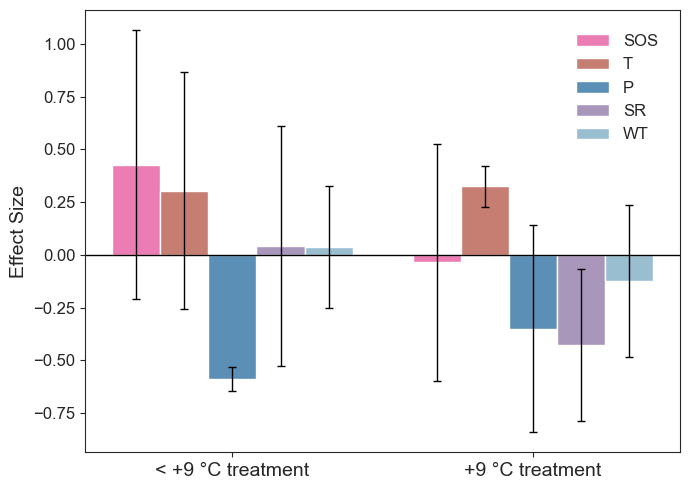

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Predictor list (must match effect_df["variable"])
predictors = ['sos', 'annual_t', 'annual_p', 'annual_r', 'annual_w']

# Updated color map (WT = distinct blue)
color_map = {
    'sos': '#ff69b4',      # pink
    'annual_t': '#d47264', # red-ish
    'annual_p': '#4d91c4', # medium blue
    'annual_r': '#a991c1', # purple
    'annual_w': '#8ec1da'  # deep blue for WT
}

# Pretty legend labels
legend_labels = {
    'sos': 'SOS',
    'annual_t': 'T',
    'annual_p': 'P',
    'annual_r': 'SR',
    'annual_w': 'WT'
}

# Groups
group1_plots = [8]
group2_plots = [17]

# Function to compute mean ± SE
def mean_se(df):
    mean = df['effect'].mean()
    se = df['effect'].std(ddof=1) / np.sqrt(len(df))
    return pd.Series({'mean': mean, 'se': se})

# Group 1 stats (✓ Fixed include_groups=False)
group1_stats = (
    effect_df[effect_df['plot'].isin(group1_plots)]
    .groupby('variable')
    .apply(mean_se, include_groups=False)
    .reset_index()
)
group1_stats['group'] = 'Group 1 (6, 20, 13, 8)'

# Group 2 stats (✓ Fixed include_groups=False)
group2_stats = (
    effect_df[effect_df['plot'].isin(group2_plots)]
    .groupby('variable')
    .apply(mean_se, include_groups=False)
    .reset_index()
)
group2_stats['group'] = 'Group 2 (17)'

# Combine groups
combined_stats = pd.concat([group1_stats, group2_stats], ignore_index=True)
combined_stats['variable'] = pd.Categorical(combined_stats['variable'], categories=predictors, ordered=True)

# Plotting
plt.figure(figsize=(7, 5))
sns.set_style("ticks")

# Bar plot
ax = sns.barplot(
    data=combined_stats,
    x='group',
    y='mean',
    hue='variable',
    palette=color_map,
    hue_order=predictors,
    order=['Group 1 (6, 20, 13, 8)', 'Group 2 (17)'],
    dodge=True
)

# Error bars
for bar, (_, row) in zip(ax.patches, combined_stats.iterrows()):
    x = bar.get_x() + bar.get_width() / 2
    y = bar.get_height()
    se = row['se']
    ax.errorbar(x, y, yerr=se, fmt='none', ecolor='black', capsize=3, capthick=1, linewidth=1)

# Replace x-tick labels (✓ Warning removed)
xtick_labels = {
    'Group 1 (6, 20, 13, 8)': '< +9 °C treatment',
    'Group 2 (17)': '+9 °C treatment'
}

labels = [xtick_labels.get(tick.get_text(), tick.get_text()) for tick in ax.get_xticklabels()]
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(labels, fontsize=14)

# Y-axis
ax.tick_params(axis='y', labelsize=12)
plt.axhline(y=0, color='black', linestyle='-', linewidth=1)

# Custom legend
handles, labels = ax.get_legend_handles_labels()
new_labels = [legend_labels.get(label, label) for label in labels]
ax.legend(
    handles, new_labels,
    title="",
    title_fontsize=12,
    fontsize=12,
    loc='upper left', bbox_to_anchor=(0.8, 0.98),
    frameon=False
)

plt.xlabel("", fontsize=14)
plt.ylabel("Effect Size", fontsize=14)
plt.tight_layout()

plt.savefig("../results/si_figures/si_fig3/spruce.jpg", dpi=300, bbox_inches='tight')
plt.show()
